In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import  precision_score, recall_score, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from scipy.stats import skew
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


Chargement des fichiers

In [2]:
eval_df = pd.read_csv("data/extrait_eval.csv")
sirh_df = pd.read_csv("data/extrait_sirh.csv")
sondage_df = pd.read_csv("data/extrait_sondage.csv")

Nettoyage du nom des colonnes

In [3]:
sirh_df = sirh_df.rename(columns={'nombre_heures_travailless' : 'nombre_heures_travaillees', 'annee_experience_totale': 'annees_experience_totale'})


In [4]:
eval_df = eval_df.rename(columns={
  'augementation_salaire_precedente' : 'augmentation_salaire_precedente', 
})

In [5]:
sondage_df = sondage_df.rename(columns={
  'annes_sous_reponsable_actuel' : 'annees_sous_reponsable_actuel'
})

### 1. Un DataFrame central, issu d’une jointure entre les fichiers de départ.

eval_number => id_employee => code_sondage

In [6]:
eval_df['id_employee'] = eval_df["eval_number"].str.extract('(\d+)').astype(int)
eval_df.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augmentation_salaire_precedente,id_employee
0,2,3,2,4,1,1,E_1,3,Oui,11 %,1
1,3,2,2,2,4,3,E_2,4,Non,23 %,2
2,4,2,1,3,2,3,E_4,3,Oui,15 %,4
3,4,3,1,3,3,3,E_5,3,Oui,11 %,5
4,1,3,1,2,4,3,E_7,3,Non,12 %,7


In [7]:
sondage_df['id_employee'] = sondage_df["code_sondage"].replace("00000", "")
sondage_df.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,id_employee
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,1
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,2
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0,4
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,5
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,7


INNER JOIN => Je veux uniquement les employés qui ont des données complètes dans les 3 csv

In [8]:
full_df = sirh_df.merge(eval_df, left_on="id_employee", right_on="id_employee", how="inner").merge(sondage_df, on="id_employee", how="inner")
full_df.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [9]:
full_df.columns

Index(['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital',
       'departement', 'poste', 'nombre_experiences_precedentes',
       'nombre_heures_travaillees', 'annees_experience_totale',
       'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel',
       'satisfaction_employee_environnement', 'note_evaluation_precedente',
       'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail',
       'satisfaction_employee_equipe',
       'satisfaction_employee_equilibre_pro_perso', 'eval_number',
       'note_evaluation_actuelle', 'heure_supplementaires',
       'augmentation_salaire_precedente', 'a_quitte_l_entreprise',
       'nombre_participation_pee', 'nb_formations_suivies',
       'nombre_employee_sous_responsabilite', 'code_sondage',
       'distance_domicile_travail', 'niveau_education', 'domaine_etude',
       'ayant_enfants', 'frequence_deplacement',
       'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel'],
      dtype='object')

suppression de variables inutiles

In [10]:
colonnes_a_supprimer = ['eval_number', 'code_sondage']
full_df.drop(columns=colonnes_a_supprimer)

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,0,3,1,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,0,3,1,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,1,3,1,2,1,Transformation Digitale,Y,Occasionnel,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2061,36,M,2571,Marié(e),Consulting,Consultant,4,80,17,...,1,3,1,23,2,Transformation Digitale,Y,Frequent,0,3
1466,2062,39,M,9991,Marié(e),Consulting,Manager,4,80,9,...,1,5,1,6,1,Transformation Digitale,Y,Occasionnel,1,7
1467,2064,27,M,6142,Marié(e),Consulting,Tech Lead,1,80,6,...,1,0,1,4,3,Infra & Cloud,Y,Occasionnel,0,3
1468,2065,49,M,5390,Marié(e),Commercial,Cadre Commercial,2,80,17,...,0,3,1,2,3,Transformation Digitale,Y,Frequent,0,8


### 2. Des cellules au sein du notebook pour calculer des statistiques descriptives sur les fichiers de départ et le fichier central, dans l’objectif de faire ressortir des différences clés entre les employés.


a. extrait_eval.csv

In [11]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augmentation_salaire_precedente            1470 non-null   object
 10  id_employee                         

b. extrait_sirh.csv

In [12]:
sirh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travaillees       1470 non-null   int64 
 9   annees_experience_totale        1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


c. extrait_sondage.csv

In [13]:
sondage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

d. fichier central 

In [14]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_travaillees                  1470 non-null   int64 
 9   annees_experience_totale                   1470 non-null   int64 
 10  annees_dans_l_entreprise            

## 3. Identification et nettoyage des colonnes quantitatives et qualitatives

In [15]:
df_normalized = full_df.copy()

# Variable pourcentage pour pouvoir l'utiliser si besoin
df_normalized['augmentation_salaire_precedente'] = df_normalized['augmentation_salaire_precedente'].apply(
    lambda x: float(x.replace(' %', '')) / 100
)

# Remplacer les 'Oui' et 'Y' en 1 et le reste en 0
bool_columns = ['heure_supplementaires', 'a_quitte_l_entreprise', 'ayant_enfants']
for col in bool_columns:
    df_normalized[col] = df_normalized[col].apply(
        lambda x: 1 if x == 'Oui' or x == 'Y' else 0
    )

df_normalized.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,1,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,1,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,1,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,3,1,5,3,4,Infra & Cloud,1,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,3,1,7,2,1,Transformation Digitale,1,Occasionnel,2,2


In [16]:
df_normalized.describe()

,id_employee,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,...,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,ayant_enfants,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000
mean,1024.865306,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252,2.721769,2.729932,...,0.161224,0.793878,2.799320,1.0,1024.865306,9.192517,2.912925,1.0,2.187755,4.123129
std,602.024335,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137,1.093082,0.711561,...,0.367863,0.852077,1.289271,0.0,602.024335,8.106864,1.024165,0.0,3.222430,3.568136
min,1.000000,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0,0.000000,0.000000
25%,491.250000,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000,2.000000,2.000000,...,0.000000,0.000000,2.000000,1.0,491.250000,2.000000,2.000000,1.0,0.000000,2.000000
50%,1020.500000,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000,3.000000,3.000000,...,0.000000,1.000000,3.000000,1.0,1020.500000,7.000000,3.000000,1.0,1.000000,3.000000
75%,1555.750000,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000,4.000000,3.000000,...,0.000000,1.000000,3.000000,1.0,1555.750000,14.000000,4.000000,1.0,3.000000,7.000000
max,2068.000000,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000,4.000000,4.000000,...,1.000000,3.000000,6.000000,1.0,2068.000000,29.000000,5.000000,1.0,15.000000,17.000000


In [17]:
colonnes_quantitatives = df_normalized.select_dtypes(include=['int64', 'float64']).columns.tolist()
colonnes_qualitatives = df_normalized.select_dtypes(include=['object']).columns.tolist()

print(f"Colonnes quantitatives ({len(colonnes_quantitatives)}): {colonnes_quantitatives}")
print(f"Colonnes qualitatives ({len(colonnes_qualitatives)}): {colonnes_qualitatives}")

Colonnes quantitatives (27): ['id_employee', 'age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travaillees', 'annees_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augmentation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'ayant_enfants', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']
Colonnes qualitatives (7): ['genre', 'statut_marital', 'departement', 'poste', 'eval_number', 'domaine_etude', 'frequence_deplacement']


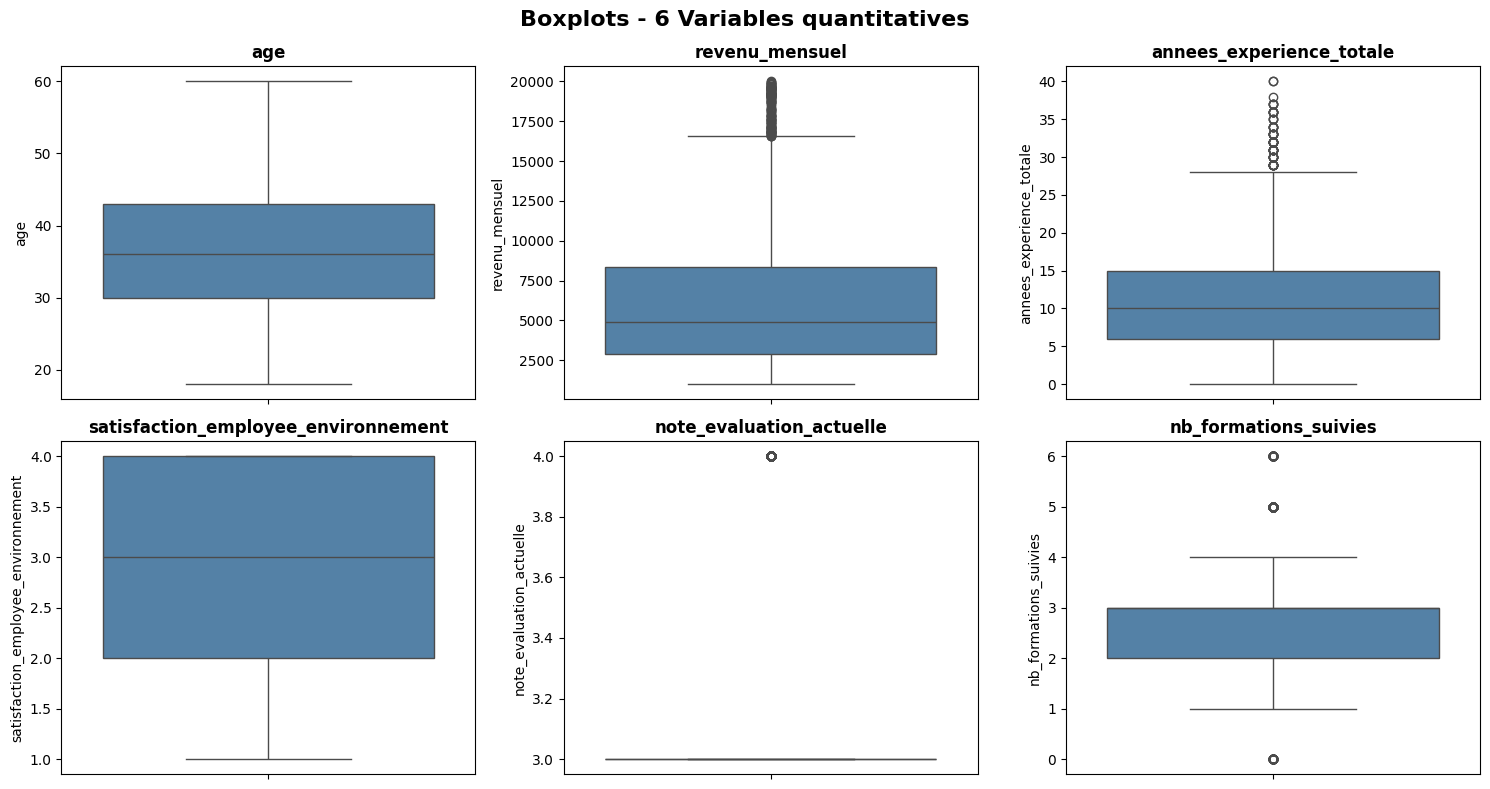

In [18]:
vars_principales = ['age', 'revenu_mensuel', 'annees_experience_totale', 
                   'satisfaction_employee_environnement', 'note_evaluation_actuelle',
                   'nb_formations_suivies']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Boxplots - 6 Variables quantitatives', 
             fontsize=16, fontweight='bold')

for i, var in enumerate(vars_principales):
    row = i // 3
    col = i % 3
    
    sns.boxplot(data=df_normalized, y=var, ax=axes[row, col], color='steelblue')
    axes[row, col].set_title(f'{var}', fontweight='bold')

plt.tight_layout()
plt.show()

### Feature Engineering

- `satisfaction_moyenne` (float) : au lieu d’avoir 4 scores séparés, on fait la moyenne des 4 variables
- `satisfaction_faible` (boolean) : 1 si la moyenne est inférieure à 2.5, sinon 0
- `stagnation_promotion` (boolean) : Permet d’identifier s’il y a eu une promotion au cours des 4 dernières années
- `evolution_evaluation` (int) : Compare la note actuelle et la précédente => retourne -1, 0 ou 1
- `augmentation_faible` (boolean) : Identifie si son augmentation est inférieure à 15 %
- `revenu_vs_median` (float) : Permet de comparer son salaire vis-à-vis de la moyenne des salaires de l’entreprise
- `peu_forme` (boolean) : Identifie s’il effectue régulièrement des formations
- `distance_excessive` (boolean) : Identifie si l’employé est à une distance supérieure à 20 km
- `junior` (boolean) : Identifie si l’employé est junior
- `senior` (boolean) : Identifie si l’employé est senior
- `experience_ratio` (float) : expérience totale / âge pour détecter les carrières précoces
- `nouveau_poste` (boolean) : Identifie s’il y a eu un nouveau poste dans l’entreprise
- `nouveau_entreprise` (boolean) : Identifie s’il est nouveau dans l’entreprise


In [19]:
df_engineered = df_normalized.copy()

# satisfaction_moyenne
df_engineered['satisfaction_moyenne'] = df_engineered[['satisfaction_employee_environnement', 
                                                      'satisfaction_employee_nature_travail',
                                                      'satisfaction_employee_equipe', 
                                                      'satisfaction_employee_equilibre_pro_perso']].mean(axis=1)

# satisfaction_faible
df_engineered['satisfaction_faible'] = df_engineered['satisfaction_moyenne'].apply(lambda x: 1 if x <= 2.5 else 0)

# stagnation_promotion
df_engineered['stagnation_promotion'] = df_engineered['annees_depuis_la_derniere_promotion'].apply(
    lambda x: 1 if x >= 4 else 0
)

# evolution_evaluation
df_engineered['evolution_evaluation'] = (df_engineered['note_evaluation_actuelle'] - df_engineered['note_evaluation_precedente']).apply(
    lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
)

# augmentation_faible
df_engineered['augmentation_faible'] = df_engineered['augmentation_salaire_precedente'].apply(
    lambda x: 1 if x < 0.15 else 0 
)

# revenu_vs_median
revenu_median = df_engineered['revenu_mensuel'].median()
df_engineered['revenu_vs_median'] = df_engineered['revenu_mensuel'].apply(
    lambda x: x / revenu_median
)

# peu_forme
df_engineered['peu_forme'] = df_engineered['nb_formations_suivies'].apply(lambda x: 1 if x <= 1 else 0)

# distance_excessive
df_engineered['distance_excessive'] = df_engineered['distance_domicile_travail'].apply(lambda x: 1 if x > 20 else 0)

# junior
df_engineered['junior'] = df_engineered['age'].apply(lambda x: 1 if x <= 30 else 0)

# senior
df_engineered['senior'] = df_engineered['age'].apply(lambda x: 1 if x >= 50 else 0)

# experience_ratio
df_engineered['experience_ratio'] = df_engineered['annees_experience_totale'] / df_engineered['age']

# nouveau_poste
df_engineered['nouveau_poste'] = df_engineered['annees_dans_le_poste_actuel'].apply(lambda x: 1 if x <= 1 else 0)

# nouveau_entreprise
df_engineered['nouveau_entreprise'] = df_engineered['annees_dans_l_entreprise'].apply(lambda x: 1 if x <= 2 else 0)

In [20]:
df_engineered.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,evolution_evaluation,augmentation_faible,revenu_vs_median,peu_forme,distance_excessive,junior,senior,experience_ratio,nouveau_poste,nouveau_entreprise
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1.218337,1,0,0,0,0.195122,0,0
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,1,0,1.042895,0,0,0,0,0.204082,0,0
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,1,0,0.424883,0,0,0,0,0.189189,1,1
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,0,1,0.591380,0,0,0,0,0.242424,0,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,0,1,0.705021,0,0,1,0,0.222222,0,1


Recherche des doublons

In [21]:
print("Recherche des doublons :")
print(f"SIRH: {sirh_df.duplicated().sum()}")
print(f"Évaluation:{eval_df.duplicated().sum()}")
print(f"Sondage:{sondage_df.duplicated().sum()}")

Recherche des doublons :
SIRH: 0
Évaluation:0
Sondage:0


Détection des salaires négatifs

In [22]:
if 'revenu_mensuel' in sirh_df.columns:
    salaires_negatifs = sirh_df['revenu_mensuel'] < 0
    print(f"Salaires négatifs:{salaires_negatifs.sum()}")
    sirh_df = sirh_df[sirh_df['revenu_mensuel'] >=
0]

Salaires négatifs:0


Vérification si première année d'expèrience < 18

In [23]:
if all(col in sirh_df.columns for col
   in ['age',
  'annees_dans_l_entreprise']):
      age_embauche = sirh_df['age'] - sirh_df['annees_dans_l_entreprise']
      probleme_age = age_embauche < 18
      print(f"Employés embauchés avant 18 ans: {probleme_age.sum()}")
      sirh_df = sirh_df[age_embauche >= 18]

Employés embauchés avant 18 ans: 0


Âge supérieur à l'âge d'entrée en
  entreprise + années d'entreprise

In [24]:
if all(col in sirh_df.columns for col
   in ['age',
  'annees_dans_l_entreprise']):
  incoherence_temporelle = sirh_df['annees_dans_l_entreprise'] > sirh_df['age']
  print(f"Incohérences temporelles :{incoherence_temporelle.sum()}")
  sirh_df = sirh_df[sirh_df['annees_dans_l_entreprise'] <= sirh_df['age']]

Incohérences temporelles :0


## 4. Construction des modèles de baseline

### Preprocessing des données

In [25]:
df_model = df_engineered.copy()

# Supprimer les colonnes inutiles AVANT de définir X et y
colonnes_a_supprimer = ['eval_number', 'code_sondage']
df_model = df_model.drop(columns=colonnes_a_supprimer)

target = 'a_quitte_l_entreprise'
y = df_model[target]

X = df_model.drop(columns=[target])

print(f"\nNombre de features: {X.shape[1]}")
print(f"Nombre d'observations: {X.shape[0]}")
print(f"Colonnes dans X: {X.columns.tolist()}")


Nombre de features: 44
Nombre d'observations: 1470
Colonnes dans X: ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travaillees', 'annees_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augmentation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'satisfaction_moyenne', 'satisfaction_faible', 'stagnation_promotion', 'evolution_evaluation', 'augmentation_faibl

Préprocessing

In [26]:

# Préparation train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.copy()
X_test = X_test.copy()

# Variables binaires => pour Label Encoding
binary_vars = ['genre', 'heure_supplementaires', 'ayant_enfants']

# Variables ordonnées => pour Ordinal Encoding
ordinal_vars = {
    'niveau_education': [1, 2, 3, 4, 5],  
    'frequence_deplacement': ['Aucun', 'Occasionnel', 'Frequent']
}

# Variables catégorielles non-ordonnées => pour One-Hot Encoding
categorical_vars = ['statut_marital', 'departement', 'poste', 'domaine_etude']

# Variables quantitatives
numeric_vars = X_train.select_dtypes(include=[np.number]).columns.tolist()
# Retirer les variables déjà traitées
numeric_vars = [col for col in numeric_vars if col not in binary_vars and col not in ordinal_vars.keys()]


# Label Encoding
label_encoders = {}
for col in binary_vars:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Ordinal Encoding
ordinal_encoders = {}
for col, order in ordinal_vars.items():
    oe = OrdinalEncoder(categories=[order])
    X_train[col] = oe.fit_transform(X_train[[col]]).ravel()
    X_test[col] = oe.transform(X_test[[col]]).ravel()
    ordinal_encoders[col] = oe

# One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_vars, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_vars, drop_first=True)

# Assurer la cohérence des colonnes entre train et test
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

extra_cols = set(X_test_encoded.columns) - set(X_train_encoded.columns)
for col in extra_cols:
    X_train_encoded[col] = 0

# Réorganiser les colonnes pour avoir le même ordre
X_test_encoded = X_test_encoded[X_train_encoded.columns]

# Vérifier l'asymétrie pour décider de la transformation log
numeric_cols_final = [col for col in X_train_encoded.columns if col in numeric_vars]
skewness_values = {}

# Si skewness > 1 alors transformation log
for col in numeric_cols_final:
    skew_val = skew(X_train_encoded[col])
    skewness_values[col] = skew_val
    
    if abs(skew_val) > 1:
        min_val = X_train_encoded[col].min()
        if min_val <= 0:
            X_train_encoded[col] = np.log1p(X_train_encoded[col] - min_val + 1)
            X_test_encoded[col] = np.log1p(X_test_encoded[col] - min_val + 1)
        else:
            X_train_encoded[col] = np.log(X_train_encoded[col])
            X_test_encoded[col] = np.log(X_test_encoded[col])


scaler = StandardScaler()
X_train_encoded[numeric_cols_final] = scaler.fit_transform(X_train_encoded[numeric_cols_final])
X_test_encoded[numeric_cols_final] = scaler.transform(X_test_encoded[numeric_cols_final])

X_train_final = X_train_encoded
X_test_final = X_test_encoded

### 1. Dummy

In [27]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_final, y_train)

dummy_pred = dummy_clf.predict(X_test_final)
dummy_proba = dummy_clf.predict_proba(X_test_final)[:, 1]

print(f"Fbeta-Score: {fbeta_score(y_test, dummy_pred, beta=2)}")
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Fbeta-Score: 0.12658227848101267
Precision: 0.12244897959183673
Recall: 0.1276595744680851


In [28]:
logistic_clf = LogisticRegression(random_state=42, max_iter=1000)
logistic_clf.fit(X_train_final, y_train)

logistic_pred = logistic_clf.predict(X_test_final)
logistic_proba = logistic_clf.predict_proba(X_test_final)[:, 1]

print(f"Fbeta-Score: {fbeta_score(y_test, logistic_pred, beta=2):.3f}")
print(f"Precision: {precision_score(y_test, logistic_pred):.3f}")
print(f"Recall: {recall_score(y_test, logistic_pred):.3f}")

Fbeta-Score: 0.401
Precision: 0.708
Recall: 0.362


In [29]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_final, y_train)

rf_pred = rf_clf.predict(X_test_final)
rf_proba = rf_clf.predict_proba(X_test_final)[:, 1]

print(f"FBeta-Score: {fbeta_score(y_test, rf_pred, beta=2):.3f}")
print(f"Precision: {precision_score(y_test, rf_pred):.3f}")
print(f"Recall: {recall_score(y_test, rf_pred):.3f}")

FBeta-Score: 0.100
Precision: 0.333
Recall: 0.085


In [30]:
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_clf.fit(X_train_final, y_train)

xgb_pred = xgb_clf.predict(X_test_final)
xgb_proba = xgb_clf.predict_proba(X_test_final)[:, 1]

print(f"FBeta-Score: {fbeta_score(y_test, xgb_pred, beta=2):.3f}")
print(f"Precision: {precision_score(y_test, xgb_pred):.3f}")
print(f"Recall: {recall_score(y_test, xgb_pred):.3f}")

FBeta-Score: 0.332
Precision: 0.609
Recall: 0.298


In [31]:
results = pd.DataFrame({
    'Modèle': ['Dummy', 'Logistic Regression', 'Random Forest', 'XGBoost'],
    'FBeta-Score': [
        fbeta_score(y_test, dummy_pred, beta=2),
        fbeta_score(y_test, logistic_pred, beta=2),
        fbeta_score(y_test, rf_pred, beta=2),
        fbeta_score(y_test, xgb_pred, beta=2)
    ],
    'Precision': [
        precision_score(y_test, dummy_pred),
        precision_score(y_test, logistic_pred),
        precision_score(y_test, rf_pred),
        precision_score(y_test, xgb_pred)
    ],
    'Recall': [
        recall_score(y_test, dummy_pred),
        recall_score(y_test, logistic_pred),
        recall_score(y_test, rf_pred),
        recall_score(y_test, xgb_pred)
    ]
})

# StratifiedKFold

results.round(3)

,Modèle,FBeta-Score,Precision,Recall
0,Dummy,0.127,0.122,0.128
1,Logistic Regression,0.401,0.708,0.362
2,Random Forest,0.100,0.333,0.085
3,XGBoost,0.332,0.609,0.298


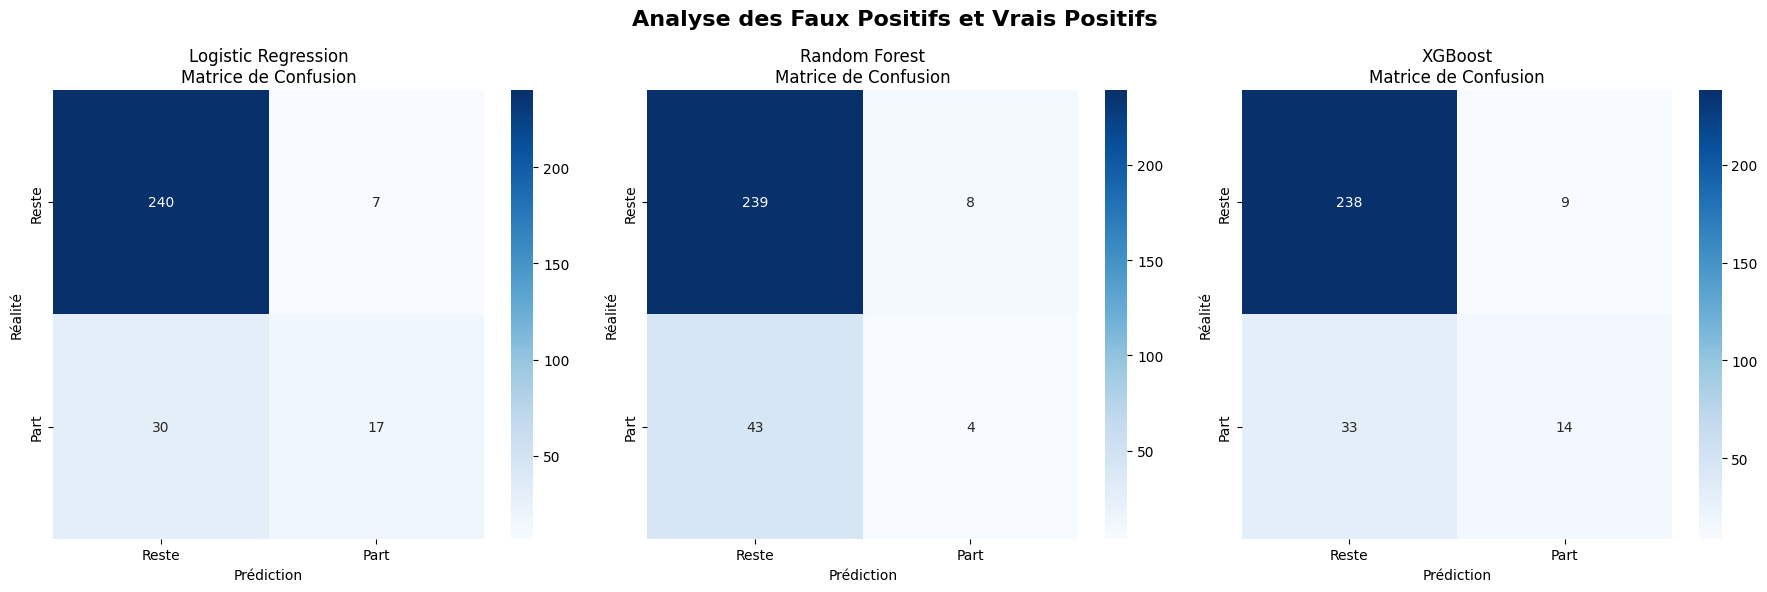

In [32]:
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Analyse des Faux Positifs et Vrais Positifs', fontsize=16, fontweight='bold')

models = {
    'Logistic Regression': logistic_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
}

for i, (name, pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, pred)
   
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Reste', 'Part'],
                yticklabels=['Reste', 'Part'],
                ax=axes[i])
    axes[i].set_title(f'{name}\nMatrice de Confusion')
    axes[i].set_xlabel('Prédiction')
    axes[i].set_ylabel('Réalité')

plt.tight_layout()
plt.show()

### Feature importance

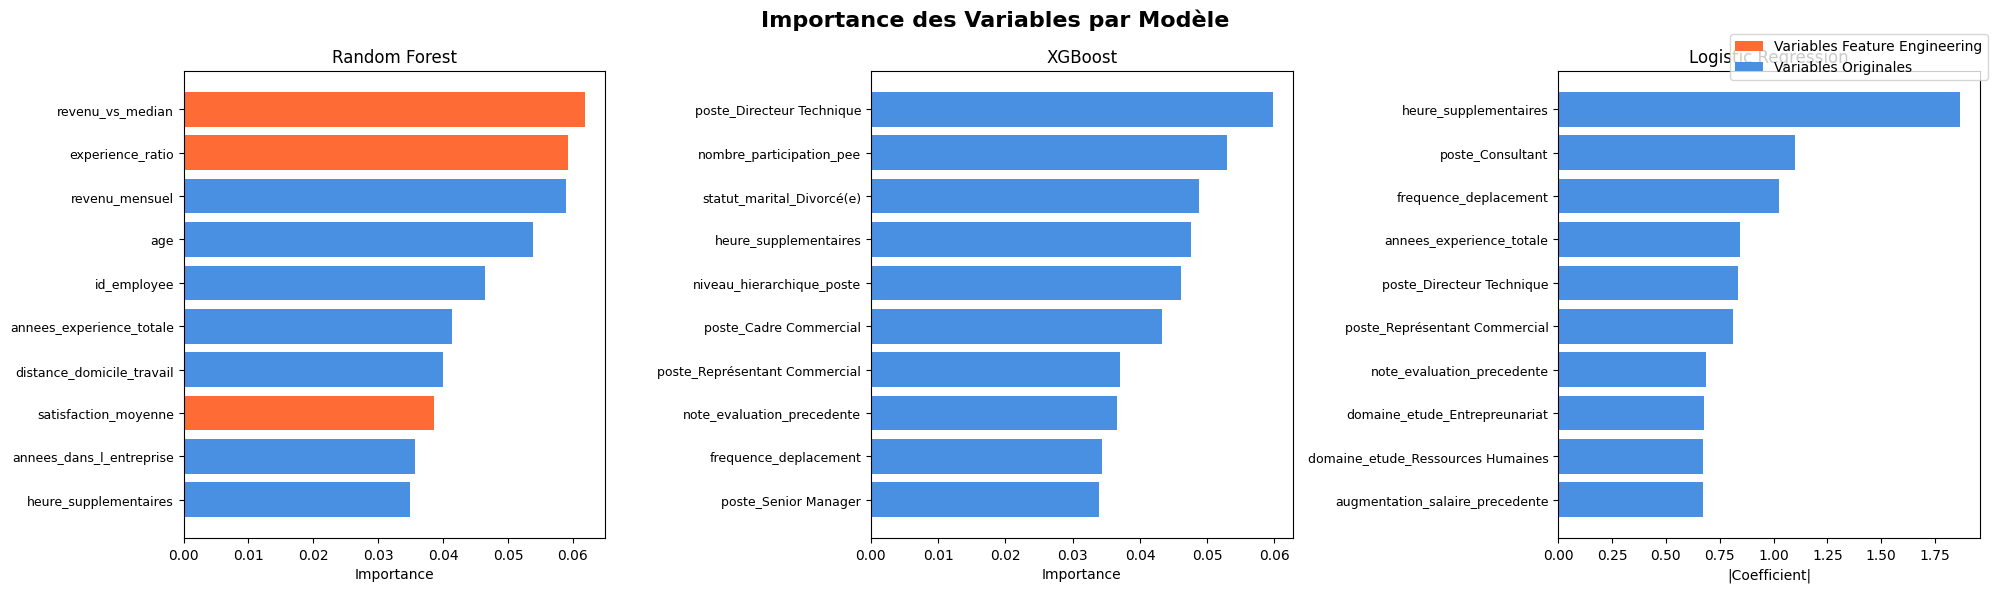

In [33]:
feature_names = X_train_final.columns.tolist()

engineered_features = [
    'satisfaction_moyenne', 'satisfaction_faible', 'stagnation_promotion',
    'evolution_evaluation', 'augmentation_faible', 'revenu_vs_median',
    'peu_forme', 'distance_excessive', 'junior', 'senior',
    'experience_ratio', 'nouveau_poste', 'nouveau_entreprise'
]

rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

logistic_coef = pd.DataFrame({
    'feature': feature_names,
    'coefficient': logistic_clf.coef_[0],
    'abs_coefficient': np.abs(logistic_clf.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

def get_colors(features, engineered_list):
    colors = []
    for feature in features:
        if feature in engineered_list:
            colors.append('#FF6B35')
        else:
            colors.append('#4A90E2')
    return colors

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Importance des Variables par Modèle', fontsize=16, fontweight='bold')

top_rf = rf_importance.head(10)
rf_colors = get_colors(top_rf['feature'], engineered_features)
axes[0].barh(range(len(top_rf)), top_rf['importance'], color=rf_colors)
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['feature'], fontsize=9)
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest')
axes[0].invert_yaxis()

top_xgb = xgb_importance.head(10)
xgb_colors = get_colors(top_xgb['feature'], engineered_features)
axes[1].barh(range(len(top_xgb)), top_xgb['importance'], color=xgb_colors)
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['feature'], fontsize=9)
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost')
axes[1].invert_yaxis()

top_log = logistic_coef.head(10)
log_colors = get_colors(top_log['feature'], engineered_features)
axes[2].barh(range(len(top_log)), top_log['abs_coefficient'], color=log_colors)
axes[2].set_yticks(range(len(top_log)))
axes[2].set_yticklabels(top_log['feature'], fontsize=9)
axes[2].set_xlabel('|Coefficient|')
axes[2].set_title('Logistic Regression')
axes[2].invert_yaxis()

legend_elements = [
    Patch(facecolor='#FF6B35', label='Variables Feature Engineering'),
    Patch(facecolor='#4A90E2', label='Variables Originales')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 0.95))

plt.tight_layout()
plt.show()

## 5. Cross-validation pour vérifier la stabilité des performances

Utilisation d'une cross-validation avec StratifiedKFold pour :
- Vérifier la stabilité des performances sur différents échantillons
- Calculer le coefficient de variation comme indicateur de stabilité



**Interprétation du coefficient de variation (CV) :**
- CV < 0.10 : Très stable
- 0.10 ≤ CV < 0.20 : Stable  
- 0.20 ≤ CV < 0.30 : Modérément stable
- CV ≥ 0.30 : Instable


In [39]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
beta=2

models = {
    'Dummy': DummyClassifier(strategy='stratified', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

cv_results = {
    'model': [],
    'fold': [],
    'fbeta_score': [],
    'precision': [],
    'recall': []
}

for model_name, model in models.items():
    print(f"{model_name}")
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_final, y_train)):

        X_cv_train, X_cv_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        

        model.fit(X_cv_train, y_cv_train)

        y_pred = model.predict(X_cv_val)

        fbeta = fbeta_score(y_cv_val, y_pred, beta=beta)
        precision = precision_score(y_cv_val, y_pred, zero_division=0)
        recall = recall_score(y_cv_val, y_pred, zero_division=0)

        cv_results['model'].append(model_name)
        cv_results['fold'].append(fold + 1)
        cv_results['fbeta_score'].append(fbeta)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        
        print(f"  Fold {fold + 1}: FBeta={fbeta:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")


Dummy
  Fold 1: FBeta=0.160, Precision=0.171, Recall=0.158
  Fold 2: FBeta=0.160, Precision=0.171, Recall=0.158
  Fold 3: FBeta=0.134, Precision=0.143, Recall=0.132
  Fold 4: FBeta=0.214, Precision=0.229, Recall=0.211
  Fold 5: FBeta=0.134, Precision=0.143, Recall=0.132
Logistic Regression
  Fold 1: FBeta=0.494, Precision=0.850, Recall=0.447
  Fold 2: FBeta=0.382, Precision=0.722, Recall=0.342
  Fold 3: FBeta=0.525, Precision=0.655, Recall=0.500
  Fold 4: FBeta=0.650, Precision=0.920, Recall=0.605
  Fold 5: FBeta=0.611, Precision=0.786, Recall=0.579
Random Forest
  Fold 1: FBeta=0.097, Precision=1.000, Recall=0.079
  Fold 2: FBeta=0.127, Precision=0.667, Recall=0.105
  Fold 3: FBeta=0.364, Precision=0.923, Recall=0.316
  Fold 4: FBeta=0.248, Precision=0.889, Recall=0.211
  Fold 5: FBeta=0.349, Precision=0.600, Recall=0.316
XGBoost
  Fold 1: FBeta=0.353, Precision=0.667, Recall=0.316
  Fold 2: FBeta=0.299, Precision=0.667, Recall=0.263
  Fold 3: FBeta=0.462, Precision=0.762, Recall=0.42

In [35]:
cv_df = pd.DataFrame(cv_results)

def calculate_cv(group):
    cv_dict = {}
    for metric in ['fbeta_score', 'precision', 'recall']:
        mean_val = group[metric].mean()
        std_val = group[metric].std()
        cv_dict[f'{metric}_cv'] = (std_val / mean_val) if mean_val > 0 else 0
    return pd.Series(cv_dict)

cv_stability = cv_df.groupby('model').apply(calculate_cv).round(4)

cv_stability


,fbeta_score_cv,precision_cv,recall_cv
model,,,
Dummy,0.2041,0.2041,0.2041
Logistic Regression,0.1970,0.1322,0.2141
Random Forest,0.5194,0.2120,0.5469
XGBoost,0.2011,0.1018,0.2214


In [36]:
# Récupération des métriques par modèle depuis les résultats de CV
model_metrics = {}
for model_name in ['Logistic Regression', 'Random Forest', 'XGBoost']:
    # Métriques CV
    cv_model_data = cv_df[cv_df['model'] == model_name]
    fbeta_mean = cv_model_data['fbeta_score'].mean()
    fbeta_std = cv_model_data['fbeta_score'].std()
    precision_mean = cv_model_data['precision'].mean()
    recall_mean = cv_model_data['recall'].mean()
    
    # Coefficient de variation
    cv_coeff = (fbeta_std / fbeta_mean) if fbeta_mean > 0 else 0
    
    model_metrics[model_name] = {
        'cv_fbeta_mean': fbeta_mean,
        'cv_fbeta_std': fbeta_std,
        'cv_precision_mean': precision_mean,
        'cv_recall_mean': recall_mean,
        'cv_coefficient': cv_coeff
    }


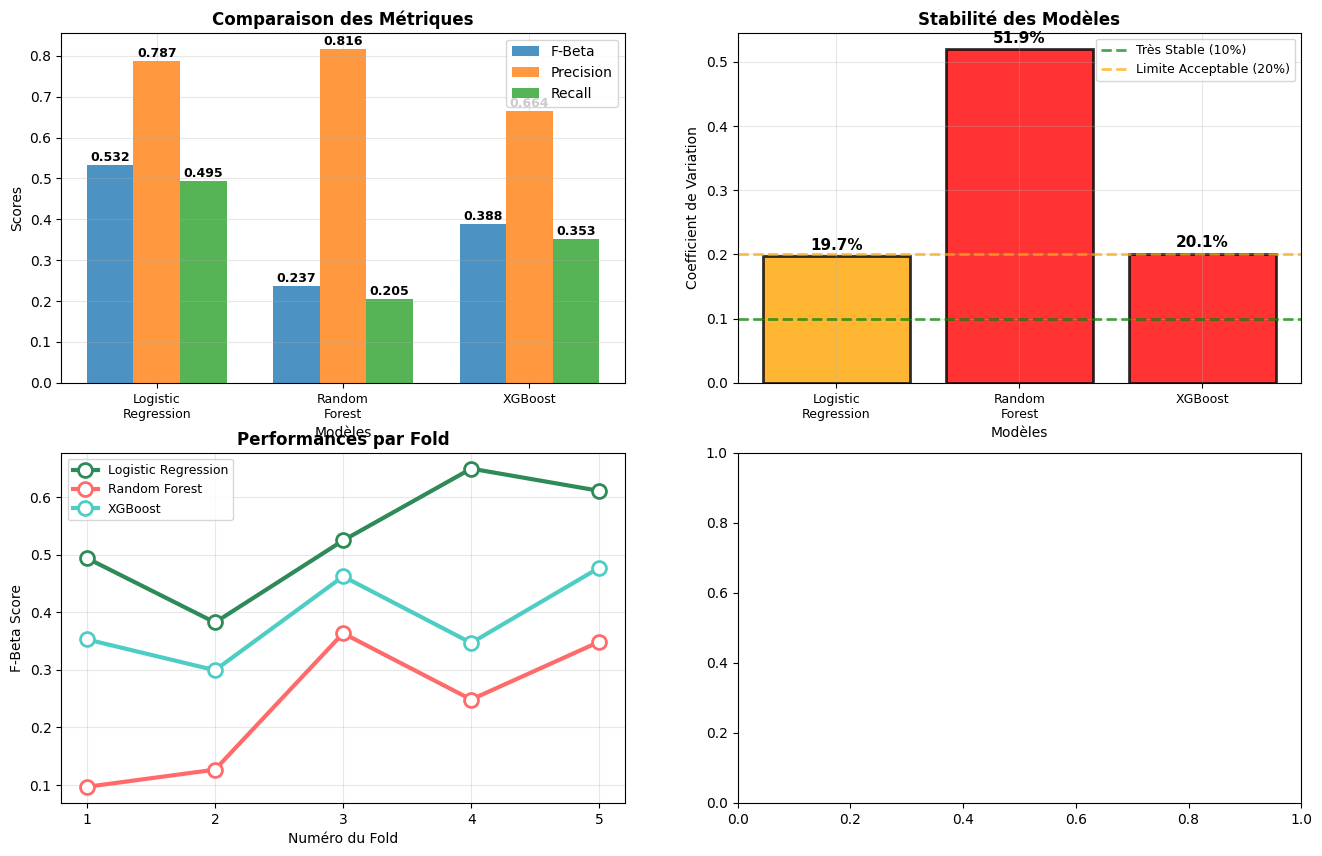

In [37]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

colors = ['#2E8B57', '#FF6B6B', '#4ECDC4']  
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
model_names = list(model_metrics.keys())


ax = axes[0, 0]
x = np.arange(len(model_names))
width = 0.25


fbeta_scores = [model_metrics[m]['cv_fbeta_mean'] for m in model_names]
precision_scores = [model_metrics[m]['cv_precision_mean'] for m in model_names]
recall_scores = [model_metrics[m]['cv_recall_mean'] for m in model_names]

bars1 = ax.bar(x - width, fbeta_scores, width, label='F-Beta', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x, precision_scores, width, label='Precision', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + width, recall_scores, width, label='Recall', color='#2ca02c', alpha=0.8)


for i, (fb, pr, rc) in enumerate(zip(fbeta_scores, precision_scores, recall_scores)):
    ax.text(i - width, fb + 0.01, f'{fb:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i, pr + 0.01, f'{pr:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i + width, rc + 0.01, f'{rc:.3f}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Modèles')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des Métriques', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3)


ax = axes[0, 1]
cvs = [model_metrics[m]['cv_coefficient'] for m in model_names]
colors_stability = ['green' if cv < 0.10 else 'orange' if cv < 0.20 else 'red' for cv in cvs]

bars = ax.bar(range(len(model_names)), cvs,
              color=colors_stability, alpha=0.8, edgecolor='black', linewidth=2)


for i, cv in enumerate(cvs):
    ax.text(i, cv + 0.01, f'{cv:.1%}',
            ha='center', fontsize=11, fontweight='bold')


ax.axhline(y=0.10, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Très Stable (10%)')
ax.axhline(y=0.20, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Limite Acceptable (20%)')

ax.set_xlabel('Modèles')
ax.set_ylabel('Coefficient de Variation')
ax.set_title('Stabilité des Modèles', fontweight='bold')
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
folds = list(range(1, 6)) 

for i, model in enumerate(models):
    model_scores = cv_df[cv_df['model'] == model]['fbeta_score'].tolist()
    ax.plot(folds, model_scores, 'o-', linewidth=3, markersize=10,
            color=colors[i], label=model, markerfacecolor='white',
            markeredgewidth=2, markeredgecolor=colors[i])

ax.set_xlabel('Numéro du Fold')
ax.set_ylabel('F-Beta Score')
ax.set_title('Performances par Fold', fontweight='bold')
ax.set_xticks(folds)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)